In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import folium
from bayes_opt import BayesianOptimization
import math
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)

In [2]:
# Read in the required data
org_path = os.getcwd()
notebook_path = org_path + '\\Notebook_Data\\'

df = pd.read_csv(notebook_path + 'cleaned_data_nodrop.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_month,day_of_week,hour_of_day,is_weekend,trip_distance,trip_heading,pickup_admin1,pickup_borough,pickup_airport,dropoff_admin1,dropoff_borough,dropoff_airport,route_distance,is_rushhour,same_area,vendorid_1,vendorid_2,passengercount_0,passengercount_1,passengercount_2,passengercount_3,passengercount_4,passengercount_5,passengercount_6,passengercount_7,passengercount_8,storeandforward_N,storeandforward_Y,pickupborough_Bronx,pickupborough_Brooklyn,pickupborough_Lower Manhattan,pickupborough_Midtown Manhattan,pickupborough_New Jersey,pickupborough_Queens,pickupborough_Staten Island,pickupborough_Upper Manhattan,pickupborough_Well Outside NYC,dropoffborough_Bronx,dropoffborough_Brooklyn,dropoffborough_Lower Manhattan,dropoffborough_Midtown Manhattan,dropoffborough_New Jersey,dropoffborough_Queens,dropoffborough_Staten Island,dropoffborough_Upper Manhattan,dropoffborough_Well Outside NYC,month_1,month_2,month_3,month_4,month_5,month_6,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9,dayofmonth_10,dayofmonth_11,dayofmonth_12,dayofmonth_13,dayofmonth_14,dayofmonth_15,dayofmonth_16,dayofmonth_17,dayofmonth_18,dayofmonth_19,dayofmonth_20,dayofmonth_21,dayofmonth_22,dayofmonth_23,dayofmonth_24,dayofmonth_25,dayofmonth_26,dayofmonth_27,dayofmonth_28,dayofmonth_29,dayofmonth_30,dayofmonth_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickupairport_JFK Airport,pickupairport_LaGuardia Airport,pickupairport_Newark Liberty Airport,dropoffairport_JFK Airport,dropoffairport_LaGuardia Airport,dropoffairport_Newark Liberty Airport
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,0,17,0,1502.171837,99.932546,New York,Midtown Manhattan,NaN,New York,Upper Manhattan,NaN,2008.4,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,6,0,1,1808.659969,-117.063997,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,2515.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,1,11,0,6379.687175,-159.608029,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,11061.2,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,2,19,0,1483.632481,-172.709884,New York,Lower Manhattan,NaN,New York,Lower Manhattan,NaN,1819.4,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,5,13,1,1187.037659,179.471551,New York,Upper Manhattan,NaN,New York,Upper Manhattan,NaN,1610.7,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Drop unwanted column from the dataframe, these are mostly categorical and cannot be used for the models below
partial_clean_df = df.drop(columns = ['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 
                                      'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                                      'month','day_of_month','day_of_week','hour_of_day', 'pickup_admin1', 'dropoff_admin1', 
                                      'pickup_airport', 'dropoff_airport'])

In [5]:
# Split into variables and labels
x = partial_clean_df.drop(columns = 'trip_duration')
y = partial_clean_df['trip_duration']

In [6]:
# Use a built in sklearn function that splits the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True, random_state = 12)

When the sets have been isolated, the training set is used to find the average speed for each borough. This information can then be added to both training and test sets without causing information leak between the two sets.

The function find_borough_speed is created so that the training set can be used to find the average driving speed in each borough.

In [7]:
def find_borough_speed(x_df, y_df):
    # Combine the dataframes
    temp_df = x_df.copy()
    temp_df['trip_duration'] = y_df
    
    # Get the average speed for each trip
    temp_df['average_speed'] = temp_df['route_distance'] / temp_df['trip_duration']
    
    # Set a maximum average speed of 25 meters per second, everything outside of that is a clear outlier
    maximum_speed = 25
    # Print the number of trips over and under the limit, this helps with visualising how much data is dumped
    print('Number of trips with average under {} kilometers per hour: {}'
          .format(maximum_speed * 3.6, len(temp_df[temp_df['average_speed'] <= maximum_speed]))) 
    print('Number of trips with average over {} kilometers per hour: {}'
          .format(maximum_speed * 3.6, len(temp_df[temp_df['average_speed'] > maximum_speed]))) 
    
    # Filter based on the above condition to create a new speed dataframe
    speed_df = temp_df[temp_df['average_speed'] <= maximum_speed]
    
    # Filter out trips that went between boroughs, then group by borough to find the average speed of that borough
    # The reason for the initial filter is because the hope is to gain some insight into the speed in just that borough
    borough_speed = speed_df[speed_df['same_area'] == 1].groupby('pickup_borough')['average_speed'].mean()
    
    # Next steps were added because of some data scarcity, sometimes Staten Island had no trips that stayed within
    
    # Find if any boroughs are missing from the borough speed overview
    pickup_borough_missing = set(speed_df['pickup_borough'].unique()) - set(borough_speed.index)
    dropoff_borough_missing = set(speed_df['dropoff_borough'].unique()) - set(borough_speed.index)
    total_borough_missing = set(list(pickup_borough_missing) + list(dropoff_borough_missing))

    # If it is missing, then just fill it in based on partial trips, where pickup or dropoff occured there
    # It should be good enough for boroughs with so few data points
    for borough in total_borough_missing:
        borough_avg_speed = speed_df[(speed_df['pickup_borough'] == borough) | 
                                     (speed_df['dropoff_borough'] == borough)]['average_speed'].mean()

        borough_speed = borough_speed.append(pd.Series(borough_avg_speed, index = [borough]))
    
    return borough_speed

In [8]:
# Run the function only on training set to prevent information leak
borough_speed = find_borough_speed(x_train, y_train)

Number of trips with average under 90.0 kilometers per hour: 995066
Number of trips with average over 90.0 kilometers per hour: 1262


The function find_borough_speed is created so that the newly gathered average speed information can be added to the training and test set for future predicions.

In [9]:
def add_borough_speed(dataframe):
    # Initalise dataframe and fill a borough speed column with NaN
    temp_df = dataframe.copy()
    temp_df['borough_average_speed'] = np.nan
    
    # Loop through every row
    for row in tqdm(temp_df.itertuples()):
        # If the trip was within the same borough
        if row.same_area == 1:
            # Then set the estimated average trip speed to the value corrispoing to that borough
            temp_df.at[row.Index, 'borough_average_speed'] = borough_speed[row.pickup_borough]
        # If not
        elif row.same_area == 0:
            # Then set the estimated average trip speed to the average speed of the pickup and dropoff boroughs
            pickup_speed = borough_speed[row.pickup_borough]
            dropoff_speed = borough_speed[row.dropoff_borough]
            temp_df.at[row.Index, 'borough_average_speed'] = (pickup_speed + dropoff_speed) / 2
    
    # Drop the pickup and dropoff locations because the model will not be able to use categorical variables
    temp_df = temp_df.drop(columns = ['pickup_borough', 'dropoff_borough'])
    
    return temp_df

In [10]:
# Run the function on both the training and test set
x_train = add_borough_speed(x_train)
x_test = add_borough_speed(x_test)

# Multiple Model Testing
This sections uses cross validation to get rough benchmark model performances for linear regression, regression trees, random forest regression and gradient boosted regression. This will then be used to identify the model to use for further training.

In [11]:
# Define a function that takes in the test set and predictions and calculates mean absolute percentage error, MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
# Create a function that fits and predicts using linear regression
def linear_regression(x_train, x_test, y_train):
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return y_pred

In [13]:
# Create a function that fits and predicts using regression tree
def regression_tree(x_train, x_test, y_train):
    model = DecisionTreeRegressor().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return y_pred

In [14]:
# Create a function that fits and predicts using random forest
def random_forest(x_train, x_test, y_train):
    model = RandomForestRegressor(n_estimators = 60, n_jobs = 3).fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return y_pred

In [15]:
# Create a function that fits and predicts using extreme gradient boosting
def xgboost(x_train, x_test, y_train):
    model = xgb.XGBRegressor(objective = 'reg:squarederror').fit(x_train, list(y_train))
    y_pred = model.predict(x_test)
    
    return y_pred

In [16]:
def run_CV(dataframe, model):
    prediction_list = list()
    actual_list = list()
    
    # Prepare a 5Fold cross validation
    kfold = KFold(5, shuffle = True)
    # Go through each possible combination of the cross validation
    for train, test in tqdm(kfold.split(dataframe)):
        # Separate into training sets
        x_train = dataframe.iloc[train].drop(columns = 'trip_duration')
        y_train = dataframe.iloc[train]['trip_duration']

        # Separate into test sets
        x_test = dataframe.iloc[test].drop(columns = 'trip_duration')
        y_test = dataframe.iloc[test]['trip_duration']

       # Get the predictions based on the input model
        y_pred = model(x_train, x_test, y_train)
        
        # Store the predictions and corrisponding test set
        prediction_list = prediction_list + list(y_pred)
        actual_list = actual_list + list(y_test.values)

    # Calculate and return the cross validation MAPE and RMSE for comparison
    mape = mean_absolute_percentage_error(actual_list, prediction_list)
    rmse = np.sqrt(mean_squared_error(actual_list, prediction_list))
    return (mape, rmse) 

In [17]:
# Combine the variables and label again into a single dataframe, this is done to fit into the cross validation function
train = x_train.copy()
train['trip_duration'] = y_train

In [18]:
templist = list()

# Define a list of all the models that will be used
model_list = [linear_regression, regression_tree, random_forest, xgboost]
model_names = ['linear_regression', 'regression_tree', 'random_forest', 'xgboost']

# Loop through each model
for i, model in enumerate(model_list):
    # Run the cross validation function to get the MAPE and RMSE value for each model
    mape, rmse = run_CV(train, model)
    # Append to a list to keep for analysis
    templist.append([model_names[i], mape, rmse])
    
# Convert the list into a dataframe for presentation purposes
final_df =  pd.DataFrame(templist)
final_df.columns = ['Model', 'MAPE', 'RMSE']

In [19]:
final_df.round(2)

,Model,MAPE,RMSE
0,linear_regression,1044.76,1021115.25
1,regression_tree,43.82,353.16
2,random_forest,34.05,251.60
3,xgboost,40.09,275.95


The results show that random forest and XGBoost perform best. However, the lack of parameter tuning has to be taken into account in this case. There might be some improvements left for the XGBoost regressor and the faster training phase makes it a stronger candidate. Especially because future implementation might rely on a seperate model for each work item and in that case random forest would be extremely time consuming.

# Further Tuning
This section covers the parameter tuning of the XGBoost regression using Baysean optimisation.

In [20]:
# Create the data matrices used by the XGBoost algorithm
dm_train = xgb.DMatrix(x_train, label = list(y_train))
dm_test = xgb.DMatrix(x_test, label = list(y_test))

The next section reads in the data containing the optimal hyperparameters for the XGBoost model. This has been tuning using AWS EC2 instance to speed up the tuning process. The dataframe is then converted into a dictionary so the XGBoost.train() function can correctly read the information. 

In [21]:
params = pd.read_csv(notebook_path + 'xgb_parameters.csv')
param_dict = dict()
for row in params.itertuples():
    if row.parameter_name == 'max_depth':
        param_dict[row.parameter_name] = int(row.value)
    else:
        param_dict[row.parameter_name] = row.value

In [22]:
# Retrain the model using the tuned parameters
final_model = xgb.train(param_dict, dm_train, num_boost_round = 100)

In [23]:
# Predict on the test set
xgb_pred = final_model.predict(dm_test)

# Print out the testing RMSE and MAPE
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print('The mean absolute percentage error of the extreme gradient boosted model is {} %'.format(xgb_mape)) 
print('The root mean squared error of the extreme gradient boosted model is {}'.format(xgb_rmse)) 

The mean absolute percentage error of the extreme gradient boosted model is 31.876010549838323 %
The root mean squared error of the extreme gradient boosted model is 239.80293472383806


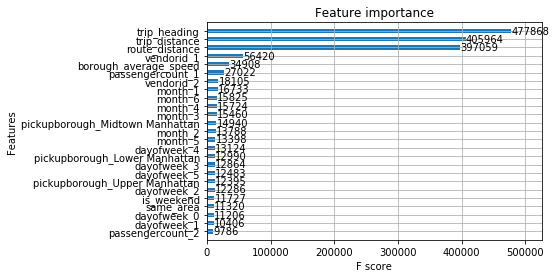

In [24]:
# Plot the feature importance in the final model
xgb.plot_importance(final_model, max_num_features = 25, height = 0.5)
plt.show()

From this plot, it can clearly be seen that the most important features are where the taxi is heading and the expected distance.

Next, try predicting on the entire training set using random forest to compare it to the recent XGBoost results

In [25]:
rf_model = RandomForestRegressor(n_estimators = 90, n_jobs = 3).fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

# Print out the testing RMSE and MAPE
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print('The mean absolute percentage error of the extreme gradient boosted model is {} %'.format(rf_mape))
print('The root mean squared error of the extreme gradient boosted model is {}'.format(rf_rmse))

The mean absolute percentage error of the extreme gradient boosted model is 33.6252291491711 %
The root mean squared error of the extreme gradient boosted model is 248.76734952989997


To compare these results to previous experiments, a benchmark estimate is generated using the similar time per unit approximation.

In [26]:
benchdf = x_train.copy()
benchdf['trip_duration'] = y_train

# Some error in that data was causing problems and has to be fixed
for row in benchdf.itertuples():
    # Sometimes the route_distance is 0 because of faults in the OSRM API
    if row.route_distance == 0:
        # These values are replaced with Haversince distance instead of dumping those rows.
        benchdf.at[row.Index, 'route_distance'] = row.trip_distance

# With these errors fixed, the seconds per kilometre measurement can be calculated for each trip
benchdf['ratio_sec_per_kilometer'] = benchdf['trip_duration'] / benchdf['route_distance']

In [27]:
# The predictions are then generated by multiplying the route distance with average ratio measure
bench_y_pred = x_test['route_distance'] * np.mean(benchdf['ratio_sec_per_kilometer'])

In [28]:
bench_mape = mean_absolute_percentage_error(y_test, bench_y_pred)
bench_rmse = np.sqrt(mean_squared_error(y_test, bench_y_pred))
print('The mean absolute percentage error of the benchmark estimate is {} %'.format(bench_mape)) 
print('The root mean squared error of the benchmark estimate is {}'.format(bench_rmse))

The mean absolute percentage error of the benchmark estimate is 131.96458966928566 %
The root mean squared error of the benchmark estimate is 2114.876431959475
